# Implementation the Fuzzy C-Means Clustering Algorithm with OCC_Testrun dataset

## Import packages and Libraries

In [45]:
# !pip install openpyxl 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


## Creating a class for Fuzzy C-Means Clustering

In [1]:
"""
Fuzzy C Means Clustering on Multi-dimensional Features

Algorithm:

Before using FCM algorithm, we transform the feature space into a 2-dimensional space by utilizing the t stochastic neighbor embedding (t-SNE) algorithm.

"""

class FCM_MD:
    def __init__(self, df):
        self.df = df
    
    # For t-SNE to perform dimentionality reduction to 2D-Space 
    def retrieve_TSNE_components(self):
        # Retrieve numeric features
        self.df = self.df.select_dtypes('number')

        # Retrieve features
        features = self.df.values

        # Create tSNE Components
        tsne = TSNE(n_components=2, verbose=1, random_state=123)

        return tsne.fit_transform(features)
    
     # For PCA to perform dimentionality reduction to 2D-Space
    def retrieve_PCA_components(self):
        # Retrieve numeric features
        self.df = self.df.select_dtypes('number')

        # Retrieve features
        features = self.df.values

        # Create tSNE Components
        pca = PCA(n_components=2, random_state=123)

        return pca.fit_transform(features)

    def fcm(self, num_clusters: int, enable_algo):
        # Instantiate FCM Algorithm
        self.model = FCM(n_clusters=num_clusters)

        if enable_algo == "TSNE":
            # Instantiate Lower Dimensional DataFrame
            result_df = pd.DataFrame()

            z = self.retrieve_TSNE_components()

            result_df['comp-1'] = z[:,0]
            result_df['comp-2']= z[:,1]
        
        elif enable_algo == "PCA":
            # Instantiate Lower Dimensional DataFrame
            result_df = pd.DataFrame()

            z = self.retrieve_PCA_components()

            result_df['comp-1'] = z[:,0]
            result_df['comp-2']= z[:,1]

        else:
            result_df = self.df.select_dtypes('number')

        # Use Features from t-SNE or PCA Components
        features = result_df.values

        # Fit FCM Model
        self.model.fit(features)

        # Centers, Labels
        self.centers = self.model.centers
        self.labels = self.model.predict(features)

        # Look at the the two artifacts as a DataFrame
        result_df['cluster_labels'] = self.labels

        return result_df




## Elbow Criterion Method to Find the Number of Cluster

In [2]:
import pandas as pd
from fcmeans import FCM
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy import interpolate

from os import getcwd, chdir

In [3]:
# Change Path to Raw folder
chdir("../..")

In [4]:
# Ignore the warning
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
# Read the DataFrame
data_path = getcwd() + "/data/raw"
df = pd.read_csv(f"{data_path}/CoalMiningCluster_57.csv")

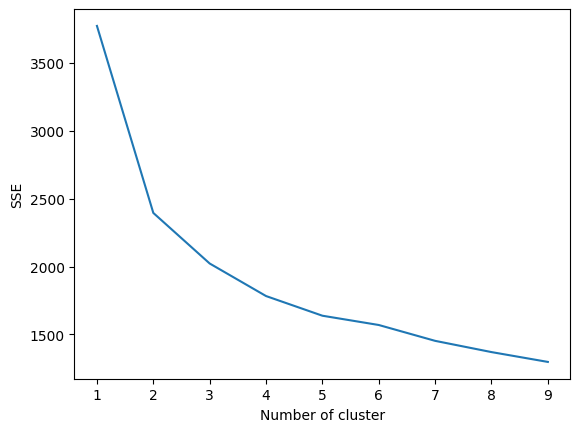

In [8]:
# Elbow Criterion
#Features are everything except SOC_Code
data = df.drop(['OCC_CODE', 'Title'], axis=1)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## Run the FCM_MD Class

In [9]:
# Instnatiate the FCM_MD Class
fcm_md = FCM_MD(df)

# Create the FCM Results with 3 clusters
results_tsne = fcm_md.fcm(num_clusters=2, enable_algo = "TSNE")
results_pca = fcm_md.fcm(num_clusters=2, enable_algo = "PCA")


# View Results DataFrame
print(results_tsne.head())
print(results_pca.head())



[t-SNE] Computing 56 nearest neighbors...
[t-SNE] Indexed 57 samples in 0.001s...
[t-SNE] Computed neighbors for 57 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 57 / 57
[t-SNE] Mean sigma: 5.993032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.667576
[t-SNE] KL divergence after 900 iterations: 0.082712
     comp-1    comp-2  cluster_labels
0 -3.790728  5.149326               1
1 -3.106532  5.351494               1
2 -2.771888  4.830345               1
3 -3.570307  4.302030               1
4 -1.208511  6.428777               1
     comp-1    comp-2  cluster_labels
0  8.161071 -3.440312               0
1  5.852392 -3.142437               0
2  5.956676 -0.767937               0
3  9.716722  0.954501               0
4  1.297271 -3.204401               0


In [10]:
results_pca1 = results_pca.drop('cluster_labels', axis=1)

results_tsne1 = results_tsne.drop('cluster_labels', axis=1)

In [11]:
# Retrieve Data with Components

results_pca1.to_csv("CoalMiningCluster_Detailed_606_PCA.csv", index=False)
results_tsne1.to_csv("CoalMiningCluster_Detailed_606_TSNE.csv", index=False)

In [12]:
# Viewing the centers
print(fcm_md.centers.shape)

cen_x = [i[0] for i in fcm_md.centers]
cen_y = [i[1] for i in fcm_md.centers]

print(cen_x)
print(cen_y)

(2, 2)
[5.258769384202301, -4.778679235600779]
[-0.2364027645819303, 0.23859121454625737]


In [13]:
type(fcm_md)

__main__.FCM_MD

### Print out the excel file of cluster data

In [14]:
df['cluster_labels'] = results_pca['cluster_labels']

In [15]:
df['cluster_labels'] = df[['cluster_labels']].apply(lambda x: x+1) 

In [16]:
# Add total number of counts for cluster labels
df['cluster_labels'].value_counts().sum()

57

In [17]:
df.to_excel("Results_In_Excel_no_TSNE.xlsx")

## Visualization

In [18]:
def prepare_visual_data(df, fcm_md):
    # Want to centers x and y
    centers = fcm_md.centers

    cen_x = [i[0] for i in centers]
    cen_y = [i[1] for i in centers]

    df['cen_x'] = df['cluster_labels'].map({i: cen_x[i] for i in df['cluster_labels'].unique()})
    df['cen_y'] = df['cluster_labels'].map({i: cen_y[i] for i in df['cluster_labels'].unique()})

    # Define colors
    #colors = ['#DF2020', '#81DF20', '#2095DF', '#964B00']
    colors = ['#DF2020', '#81DF20']
    # Create color scheme
    df['c'] = df['cluster_labels'].map({i : colors[i] for i in range(len(colors))})

    return df, colors, cen_x, cen_y

result_df, colors, cen_x, cen_y = prepare_visual_data(results_pca, fcm_md)

In [19]:
result_tsne_df, colors, cen_x, cen_y = prepare_visual_data(results_tsne, fcm_md)

### Scatter Plot

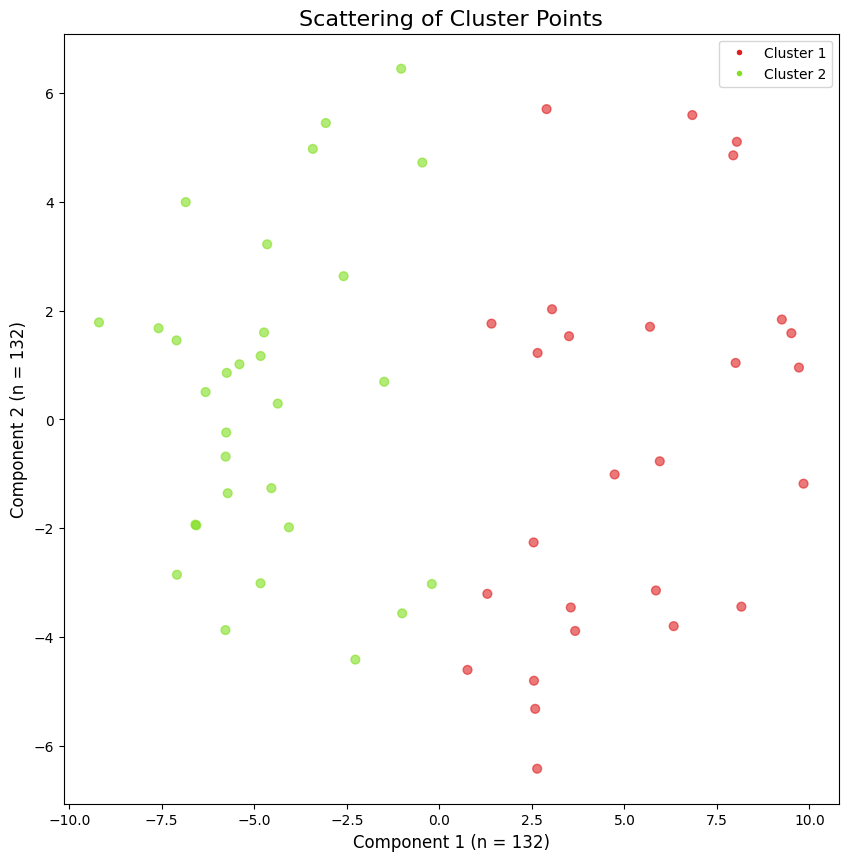

In [20]:
# Scatter Plot
def create_scatter(df, colors):
    plt.figure(figsize=(10,10))
    plt.scatter(df['comp-1'], df['comp-2'], c=df['c'], alpha=0.6, s=40)
    plt.title("Scattering of Cluster Points", size=16)
    plt.xlabel(f'Component 1 (n = {fcm_md.df.shape[1]})', size=12)
    plt.ylabel(f'Component 2 (n = {fcm_md.df.shape[1]})', size=12)
    label_handles = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}',
                    markerfacecolor=mcolor, markersize=5) for i,
                    mcolor in enumerate(colors)]
    plt.legend(handles=label_handles, loc='upper right')
    plt.show()


create_scatter(result_df, colors)

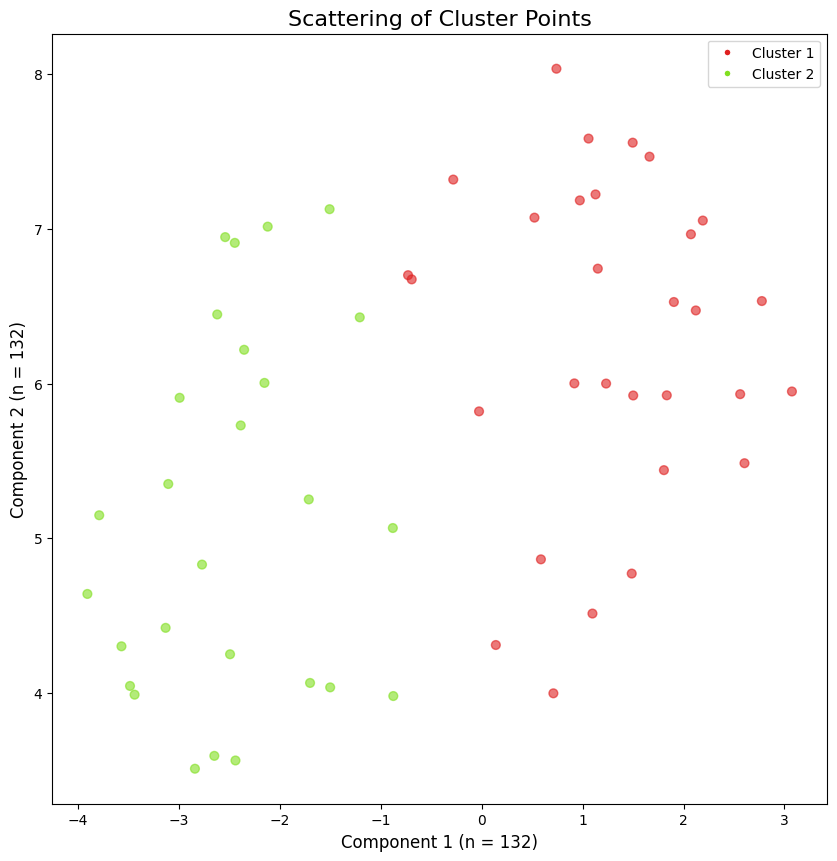

In [21]:
create_scatter(result_tsne_df, colors)

### Contour Plot

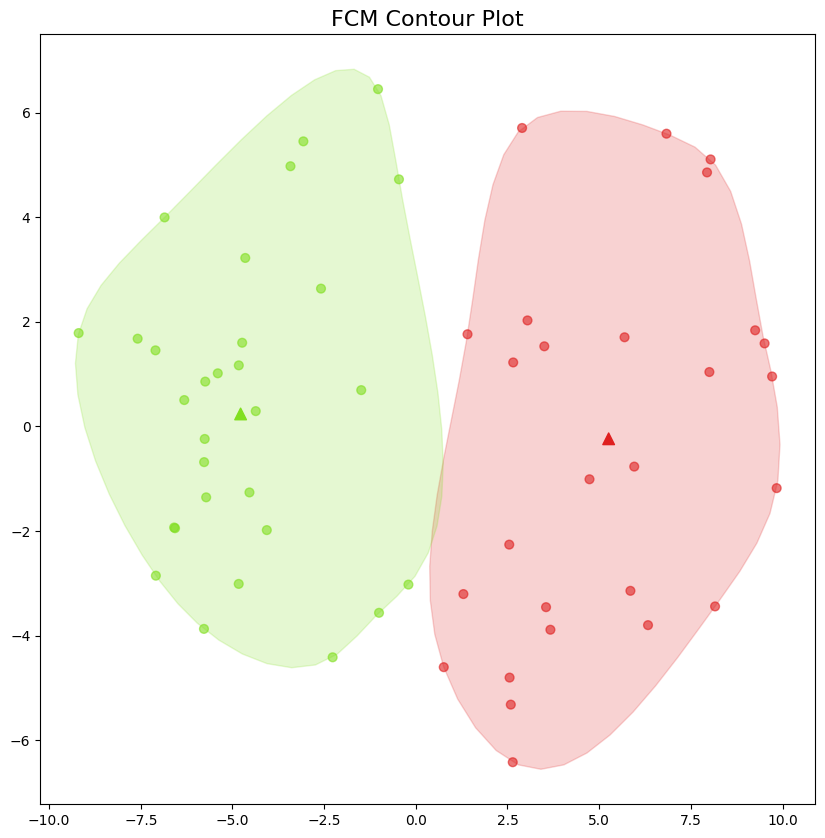

In [22]:
# Contour Plot
def create_contour_plot(df, colors, cen_x, cen_y):
    plt.figure(figsize=(10,10))

    plt.title("FCM Contour Plot", size=16)
    
    # Scatter components
    plt.scatter(df['comp-1'], df['comp-2'], c=df.c, alpha=0.6, s=40)

    # Scattering the centers for both components
    plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

    # Go through each cluster and build convex hulls
    for i in df['cluster_labels'].unique():
        # Get the Convex Hull
        points = df[df['cluster_labels'] == i][['comp-1', 'comp-2']].values
        hull = ConvexHull(points)

        x_hull = np.append(points[hull.vertices, 0],
                            points[hull.vertices, 0][0])
        
        y_hull = np.append(points[hull.vertices, 1],
                            points[hull.vertices, 1][0])
        
        # Interpolation
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)

        # Plot Shape
        plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)


    # plt.xlim(0, 200)
    # plt.ylim(0, 200)
    plt.show()

create_contour_plot(result_df, colors, cen_x, cen_y)

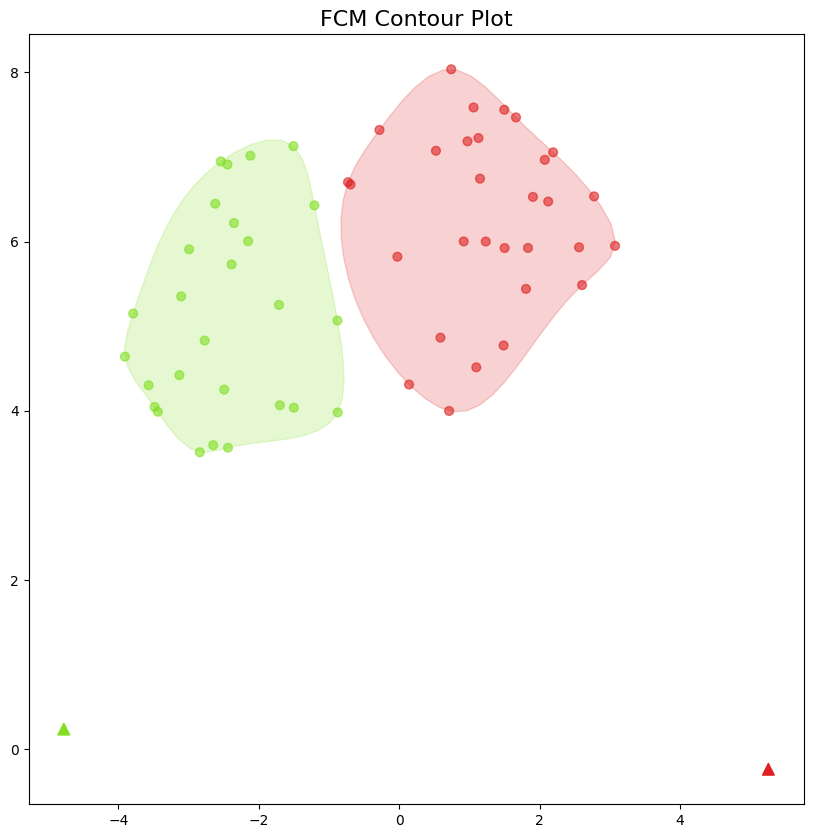

In [23]:
create_contour_plot(result_tsne_df, colors, cen_x, cen_y)

### Point out the data points that belong to more than one cluster

In [26]:
# Reading in cluster membership data from R code
cluster_member_df = pd.read_csv(f"{data_path}/CoalMiningCluster_57_Result.csv")

In [27]:
cluster_member_df.head()

cols = cluster_member_df.columns.tolist()

# Drop Unnamed Column
cluster_member_df.drop(cols[0], axis=1, inplace=True)

# Find Difference Between Cluster 1 and Cluster 2
cluster_member_df['prob_diff'] = abs(cluster_member_df['Cluster 2'] - cluster_member_df['Cluster 1'])

# Common Points
common_points = cluster_member_df[cluster_member_df['prob_diff'] <= 0.09]

common_points

,Cluster 1,Cluster 2,prob_diff
15,0.500281,0.499719,0.000562
19,0.467951,0.532049,0.064097
73,0.466239,0.533761,0.067522
79,0.490661,0.509339,0.018678
83,0.499723,0.500277,0.000554
...,...,...,...
533,0.487900,0.512100,0.024201
542,0.530171,0.469829,0.060341
543,0.537503,0.462497,0.075006
586,0.531451,0.468549,0.062901


In [35]:
# Common Points
common_points_10percent = cluster_member_df[cluster_member_df['prob_diff'] <= 0.10]

common_points_10percent.shape

(77, 3)

In [36]:
def prob_threshold(p: float):
    return cluster_member_df[cluster_member_df['prob_diff'] <= p]

common_points = {}

for p_val in [0.08, 0.085, 0.09, 0.095, 0.1]:
    common_points[p_val] = prob_threshold(p_val)


for key in common_points:
    frame = common_points[key]

    print(f"There are {frame.shape[0]} points in common between clusters when probability difference is less than or equal to {key}.")
    print(f"DataFrame for {key} \n {frame.head()}")

There are 59 points in common between clusters when probability difference is less than or equal to 0.08.
DataFrame for 0.08 
     Cluster 1  Cluster 2  prob_diff
15   0.500281   0.499719   0.000562
19   0.467951   0.532049   0.064097
73   0.466239   0.533761   0.067522
79   0.490661   0.509339   0.018678
83   0.499723   0.500277   0.000554
There are 64 points in common between clusters when probability difference is less than or equal to 0.085.
DataFrame for 0.085 
     Cluster 1  Cluster 2  prob_diff
15   0.500281   0.499719   0.000562
19   0.467951   0.532049   0.064097
73   0.466239   0.533761   0.067522
79   0.490661   0.509339   0.018678
83   0.499723   0.500277   0.000554
There are 69 points in common between clusters when probability difference is less than or equal to 0.09.
DataFrame for 0.09 
     Cluster 1  Cluster 2  prob_diff
15   0.500281   0.499719   0.000562
19   0.467951   0.532049   0.064097
73   0.466239   0.533761   0.067522
79   0.490661   0.509339   0.018678
83   

In [37]:
cluster_view = df[df.columns[-2:]]

df.iloc[6][['SOC_Code', 'Title', 'cluster_labels'] + df.columns[-2:].tolist()]

SOC_Code                                   11-3021.00
Title             Computer and Information Systems Ma
cluster_labels                                      1
Job_Zone                                            4
cluster_labels                                      1
Name: 6, dtype: object

In [38]:
formatted_df = df[['SOC_Code', 'Title', 'cluster_labels']]

formatted_df

,SOC_Code,Title,cluster_labels
0,11-1011.00,Chief Executives,1
1,11-1021.00,General and Operations Managers,1
2,11-2011.00,Advertising and Promotions Managers,1
3,11-2021.00,Marketing Managers,1
4,11-2022.00,Sales Managers,1
...,...,...,...
601,53-7064.00,"Packers and Packagers, Hand",2
602,53-7065.00,Stockers and Order Fillers,1
603,53-7072.00,"Pump Operators, Except Wellhead Pum",2
604,53-7081.00,Refuse and Recyclable Material Coll,2


In [39]:
def cluster_member_per_title(titles, df):
    # create empty dictionary to store titles and cluster membership
    title_dict = {}

    for title in titles:
        spec_result = ','.join([str(value) for value in df[df['Title'] == title]['cluster_labels'].value_counts().index.tolist()])
        title_dict[title] = spec_result
    
    return title_dict

membership_results = cluster_member_per_title(formatted_df['Title'].unique(), formatted_df)

group_results = {k:v for k,v in membership_results.items() if ',' in v}

group_results

{}

In [40]:
# Specific DataFrames per Cluster Label

cluster_title_results = {}

for label in formatted_df['cluster_labels'].unique():
    label_df = formatted_df[formatted_df['cluster_labels'] == label]
    cluster_title_results[label] = label_df.drop('cluster_labels', axis=1)

cluster_title_results.keys()

cluster_title_results[1]

,SOC_Code,Title
0,11-1011.00,Chief Executives
1,11-1021.00,General and Operations Managers
2,11-2011.00,Advertising and Promotions Managers
3,11-2021.00,Marketing Managers
4,11-2022.00,Sales Managers
...,...,...
480,49-9061.00,Camera and Photographic Equipment R
525,51-5111.00,Prepress Technicians and Workers
533,51-6052.00,"Tailors, Dressmakers, and Custom Se"
581,53-2021.00,Air Traffic Controllers


In [41]:
# from pandas import ExcelWriter

# with ExcelWriter("Codes_Titles_per_Cluster.xlsx") as writer:
#     for label in cluster_title_results.keys():
#         cluster_title_results[label].to_excel(writer, sheet_name=f"Cluster {label} Codes and Titles", index=False)